In [1]:
import numpy as np
import bfm
import neal
from dwave.samplers import SimulatedAnnealingSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import itertools
import pprint

In [2]:
# Nbits (列数)
N = 16
# 反復回数
N_iter = 600
# 初期学習データ (行数)
N_initial_samples = 10

# epoch数: 2000
# 学習率: 0.01
# 1回に作られるサンプル数: 3

sampler = SimulatedAnnealingSampler()
sampler.parameters["seed"] = 0



### QUBO模型の定義

QUBOとはQuadratic Unconstrained Binary Optimizationの略で、制約条件なし0-1整数二次計画問題のことです。

QUBO模型は以下のような形のバイナリ変数の多項式関数で表されます。

$
\displaystyle H = \sum_{i<j} J_{ij} q_i q_j + \sum_i h_i q_i \quad q_i\in\{0, +1 \}
$

(FixstarsAmplify 1-tutorial-basic.jpynbより引用)

In [3]:
## オリジナルブラックボックス関数

# 線形(1次)のQUBOをブラックボックス関数として設定
# 上記に従ってコスト関数を設定

def cost_function(x, h):
    cost = 0

    # 1次の項について
    for i in range(N):
        cost += h[i] * x[i]

    return cost

In [4]:
# Create initial samples
# 初期入力データを作成する

# random.default_rng(0)ではシード値0でdefault_rngのインスタンスrngを作る
rng = np.random.default_rng(0)

# xs_realとして、N個(行) × Nビット(列)の0, 1の整数乱数配列を生成する。
# xsはN_initial_samples個(行) × Nビット(列)の0, 1の整数乱数配列とする。
xs = rng.integers(2, size=(N_initial_samples, N))
# print(f"xs_real: {xs_real}")
print(f"xs: {xs}")

# hをランダムに作成
h = rng.uniform(-1, 1, size=N)
print(f"h: {h}")

# コスト関数の返り値を求める
# itertools.product(range(a), repeat=N)とすることで、a未満の自然数で構成されるNビット列を生成できる。
ys_all =[cost_function(x, h)for x in itertools.product(range(2), repeat=N)]
ys = [(cost_function(x, h)/abs(min(ys_all))) for x in xs]
print(f"ys: {ys}")

xs: [[1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0]
 [1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0]
 [1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1]
 [0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0]
 [1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1]
 [1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1]
 [0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0]]
h: [ 0.51545769 -0.00515461  0.05862432  0.5715714  -0.1706883   0.46896714
  0.42228576  0.86411937 -0.77013473  0.45803023  0.85484786  0.93585238
 -0.97058739  0.72728018  0.96239008  0.91442036]
ys: [2.322468074114368, 2.1203103433567385, 1.654265499109041, 2.492300152442698, 2.5693376773297816, 1.70794922575624, 0.3757956151099466, 1.2460767039372338, 2.4782468862597886, 0.49672829025545356]


In [6]:
## FMA

dataset = bfm.Dataset("all")
for x, l in zip(xs, ys):
    dataset.add(x.astype(int), l)

# Construct FM
# ビット数N, ハイパーパラメータK=8, seed=2でFM構築
model = bfm.FactorizationMachine(N, 8, seed = 0)
# Construct optimizer
optimizer = bfm.Optimizer("Adam")
# loss(学習誤差)を格納するリストを作成
list_loss =[]
# 2000回のepochを行うFMをN_iter回まわす
for _ in range(N_iter):
    # Training
    # model.trainメソッドで2000回, 学習率0.01で学習
    # lossの中には訓練の中で得られる学習誤差が出力される
    loss = model.train(optimizer, dataset, epoch=2000, learning_rate=1.0e-2)
    list_loss.append(loss)
    # Get likely solutions
    qubo, _ , _ = model.to_coefficients()
    # 1回に3個のサンプルを生成する
    res = sampler.sample_qubo(qubo, num_reads=1)
    # Add the likely solutions to training dataset
    #res.record["sample"]に解が含まれており、解を2の補数表現に直して新しい解と2の補数表現をデータセットへ追加
    for x in res.record["sample"]:
        l = cost_function(x, h)/abs(min(ys_all))
        #モデルに初期サンプルをアペンドするので、合計のサンプル数はN_iter×(1回に3個のサンプルを生成)+ N_initial_samplesとなる
        # datasetはset(集合型)で、重複を許さないから計算量を少なくできる。
        dataset.add(x.astype(int), l)
        # ysにlをアペンド
        ys.append(l)

In [7]:
print(len(list_loss))

600


In [8]:
print(len(ys))

610


In [9]:
print(f"ys: {ys}")
print(f"min_ys: {min(ys)}")
print(f"ys[-1]: {ys[-1]}")
print(res.record["sample"])
print(ys)
print(dataset)
print (dir(model))
print(type(xs))
# print(np.array(list_loss).shape)

ys: [2.322468074114368, 2.1203103433567385, 1.654265499109041, 2.492300152442698, 2.5693376773297816, 1.70794922575624, 0.3757956151099466, 1.2460767039372338, 2.4782468862597886, 0.49672829025545356, 2.0651461280195282, 1.2166498495429323, 1.8704162340838248, 1.6439358015474268, 1.8891099494452883, 0.6989416926644862, 0.5072980890316895, 2.021500253507046, 0.107385075510281, 0.660296811280253, -0.15915523004453855, 0.7397207868184748, 1.777257475495713, -0.5379908411500115, -0.5379908411500115, -0.758325527699953, 0.21241488934047761, -0.758325527699953, -0.758325527699953, -0.758325527699953, -0.4830458191271679, -0.758325527699953, -0.758325527699953, 0.01701563444525379, -0.758325527699953, -0.758325527699953, -0.758325527699953, -0.03853715488527877, -0.758325527699953, 0.8468603535508255, -0.758325527699953, -0.758325527699953, -0.758325527699953, -0.758325527699953, -0.758325527699953, -0.758325527699953, -0.758325527699953, -0.758325527699953, -0.758325527699953, -0.75832552769

In [10]:
model.predict(list(xs[0]))

[2.3238120079040527]

In [11]:
# dataset.to_labels()で出力ysが得られる
# dataset.to_inputs()で入力xsが得られる。

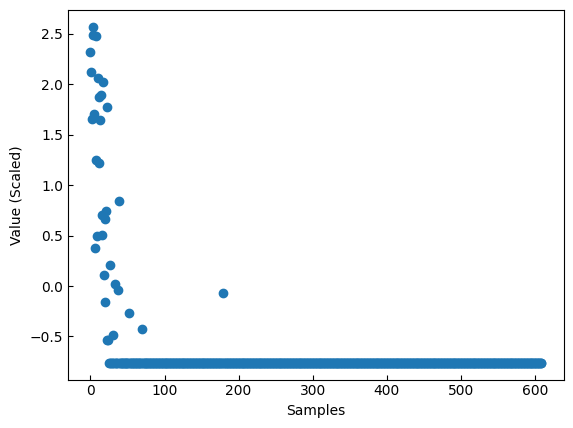

In [12]:
# サンプル数に対するValue値
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(ys, 'o')
plt.xlabel('Samples')
plt.ylabel('Value (Scaled)')
# plt.ylim([-1.0,1.0])
plt.show()

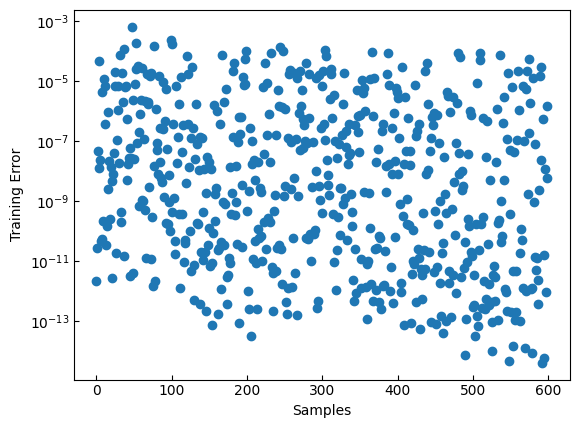

In [13]:
# サンプル数に対する学習誤差
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.yscale("log")
plt.plot(list_loss, 'o')
plt.xlabel('Samples')
plt.ylabel('Training Error')
plt.show()

In [14]:
print(dataset)

In [15]:
# 得られた全てのysのリスト
print(dataset.to_labels())
# 得られた全てのysに対するxsのリスト。ただし1ビットずつ区切られているため、得られたサンプル数が得られる
print(dataset.to_inputs())

[-0.06545475125312805, 2.0651462078094482, 2.4782469272613525, -0.1591552346944809, -0.0385371558368206, 0.3757956027984619, 0.6602967977523804, 0.21241489052772522, 1.7079492807388306, 2.492300033569336, 0.4967283010482788, 0.1073850765824318, 2.5693376064300537, 1.6439357995986938, -0.2717316448688507, 1.6542655229568481, 2.3224680423736572, 1.8891099691390991, 2.0215003490448, 0.8468603491783142, 0.698941707611084, -0.4830458164215088, 0.01701563410460949, -0.42951032519340515, 1.2166498899459839, 2.1203103065490723, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.7583255171775818, -0.758325517

In [16]:
# datasetは辞書型になっていて、キーが1, 1, 0, 0, 0, 1, ...の16ビットのinputs, それに対応する値が格納されている。これが610個(サンプル数個)あるのでshapeは[610, 16]
# ただし、datasetはRust言語で書かれているため、そのまま取り出すことができないことから、dataset.to_inputsとするとキーが1次元で全て表示されてしまう仕様になっている。
print(dataset.shape())
# reshapeするためにnumpyに変換している
numpy_dataset_inputs = np.array(dataset.to_inputs()).reshape(dataset.shape())
# # 16ビットの入力がサンプル数個あるnumpyとするためにreshapeを実行
# numpy_dataset_inputs_new = numpy_dataset_inputs.reshape(dataset.shape())

[610, 16]


In [17]:
list_dataset_inputs = list(numpy_dataset_inputs)

In [18]:
print(list_dataset_inputs)

[array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]), array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]), array([1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]), array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]), array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]), array([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]), array([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]), array([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0]), array([1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]), array([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]), array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]), array([1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1]), array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]), array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]), array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]), array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]), array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]), array([1, 0, 1, 0, 0, 1, 0, 0,

In [19]:
error = []
for idx, y in enumerate(ys):
    error.append(abs((cost_function(numpy_dataset_inputs[idx], h)) /abs(min(ys_all)) -y))

In [20]:
print(error)

[2.38792282292294, 0.055164215337210276, 0.8239813871507475, 2.651455382487237, 2.6078748322150602, 1.3321536106462935, 0.2845011961703064, 1.0336618145967562, 0.7702976605035485, 1.9955718621872447, 1.5684178377640747, 1.1092647740326513, 0.6989214432459567, 0.0, 2.1608415859313816, 0.9553238064445548, 1.8151699850826786, 0.13239030406175778, 1.9141151779967651, 0.18656354227057248, 0.8580969227090248, 1.2227666059456426, 1.760241841050459, 0.10848051705668754, 1.754640690692944, 2.8786358710566917, 0.9707404170404306, 0.0, 0.0, 0.0, 0.2752797085727851, 0.0, 0.0, 0.7753411621452068, 0.0, 0.0, 0.0, 0.7197883728146742, 0.0, 1.6051858812507784, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4865938912138597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.328815203606629, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 